# Exercises from Think Stats, 2nd Edition

http://thinkstats2.com

Copyright 2016 Allen B. Downey

MIT License: https://opensource.org/licenses/MIT


In [3]:
from __future__ import print_function, division

%matplotlib inline

import warnings
warnings.filterwarnings('ignore', category=FutureWarning)

import numpy as np
import pandas as pd

import random

import thinkstats2
import thinkplot

import survival

## Exercises

**Exercise:**    In NSFG Cycles 6 and 7, the variable `cmdivorcx` contains the date of divorce for the respondent’s first marriage, if applicable, encoded in century-months.

Compute the duration of marriages that have ended in divorce, and the duration, so far, of marriages that are ongoing. Estimate the hazard and survival curve for the duration of marriage.

Use resampling to take into account sampling weights, and plot data from several resamples to visualize sampling error.

Consider dividing the respondents into groups by decade of birth, and possibly by age at first marriage.

In [4]:
# Loading the cycle 6 and 7 data from the nsfg file.
resp6 = survival.ReadFemResp2002()
resp7 = survival.ReadFemResp2010()

In [5]:
def CleanData(resp):
    """Cleans respondent data.

    resp: DataFrame
    """
    resp.cmdivorcx.replace([9998, 9999], np.nan, inplace=True)

    resp['notdivorced'] = resp.cmdivorcx.isnull().astype(int)
    resp['duration'] = (resp.cmdivorcx - resp.cmmarrhx) / 12.0
    resp['durationsofar'] = (resp.cmintvw - resp.cmmarrhx) / 12.0

    month0 = pd.to_datetime('1899-12-15')
    dates = [month0 + pd.DateOffset(months=cm) 
             for cm in resp.cmbirth]
    resp['decade'] = (pd.DatetimeIndex(dates).year - 1900) // 10

In [6]:
CleanData(resp6)
married6 = resp6[resp6.evrmarry==1]

CleanData(resp7)
married7 = resp7[resp7.evrmarry==1]

In [7]:
# Solution goes here
married6.shape

(4126, 16)

In [73]:
married6.head

<bound method NDFrame.head of       caseid  cmbirth  evrmarry  cmmarrhx  cmdivorcx  parity     finalwgt  \
1       5012      718      True     974.0     1077.0       1  4744.191350   
2      11586      708      True     910.0      938.0       1  4744.191350   
5        845      727      True     937.0        NaN       6  4705.681352   
8       8656      780      True    1003.0        NaN       3  6520.021223   
10      5917      714      True     953.0        NaN       2  3488.586646   
...      ...      ...       ...       ...        ...     ...          ...   
7634    1282      798      True    1057.0     1119.0       2  4055.209574   
7635    2954      862      True    1069.0        NaN       1  4087.693768   
7636    4964      727      True     953.0        NaN       6  3703.220316   
7637     143      808      True    1060.0     1151.0       0  4496.050707   
7638   11018      811      True    1032.0     1053.0       0  6565.818007   

      cmintvw   agemarry        age  year  de

In [72]:
married6.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4126 entries, 1 to 7638
Data columns (total 16 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   caseid         4126 non-null   int64  
 1   cmbirth        4126 non-null   int64  
 2   evrmarry       4126 non-null   bool   
 3   cmmarrhx       4089 non-null   float64
 4   cmdivorcx      982 non-null    float64
 5   parity         4126 non-null   int64  
 6   finalwgt       4126 non-null   float64
 7   cmintvw        4126 non-null   int64  
 8   agemarry       4089 non-null   float64
 9   age            4126 non-null   float64
 10  year           4126 non-null   int64  
 11  decade         4126 non-null   int64  
 12  fives          4126 non-null   int64  
 13  notdivorced    4126 non-null   int32  
 14  duration       977 non-null    float64
 15  durationsofar  4089 non-null   float64
dtypes: bool(1), float64(7), int32(1), int64(7)
memory usage: 503.7 KB


In [76]:
df6 = married6[["caseid","cmmarrhx","cmdivorcx","notdivorced","duration","durationsofar"]]
df6

,caseid,cmmarrhx,cmdivorcx,notdivorced,duration,durationsofar
1,5012,974.0,1077.0,0,8.583333,21.583333
2,11586,910.0,938.0,0,2.333333,27.000000
5,845,937.0,NaN,1,NaN,24.750000
8,8656,1003.0,NaN,1,NaN,19.500000
10,5917,953.0,NaN,1,NaN,23.333333
...,...,...,...,...,...,...
7634,1282,1057.0,1119.0,0,5.166667,14.250000
7635,2954,1069.0,NaN,1,NaN,13.250000
7636,4964,953.0,NaN,1,NaN,22.833333
7637,143,1060.0,1151.0,0,7.583333,14.166667


In [8]:
married7.shape

(5534, 17)

In [12]:
married7.describe()

,caseid,cmbirth,cmmarrhx,cmdivorcx,parity,wgtq1q16,cmintvw,finalwgt,agemarry,age,year,decade,fives,notdivorced,duration,durationsofar
count,5534.000000,5534.000000,5518.000000,1554.000000,5534.000000,5534.000000,5534.000000,5534.000000,5518.000000,5534.000000,5534.000000,5534.000000,5534.000000,5534.000000,1551.000000,5518.000000
mean,32988.456451,888.258403,1174.747735,1201.182754,1.847488,5945.751515,1302.120528,5945.751515,23.871934,34.488510,73.475425,6.891218,14.291652,0.719190,6.318450,10.613734
std,4615.408885,77.573128,82.499426,76.833921,1.396419,6258.589570,14.316077,6258.589570,4.709401,6.388609,6.467706,0.719272,1.330812,0.449435,4.545981,6.776759
min,26141.000000,740.000000,920.000000,960.000000,0.000000,44.023984,1278.000000,44.023984,10.916667,17.083333,61.000000,6.000000,12.000000,0.000000,-6.916667,0.000000
25%,29161.500000,824.000000,1115.250000,1151.000000,1.000000,1858.135743,1289.000000,1858.135743,20.333333,29.416667,68.000000,6.000000,13.000000,0.000000,2.916667,4.916667
50%,32166.500000,885.000000,1183.000000,1213.000000,2.000000,3634.447751,1303.000000,3634.447751,23.166667,34.833333,73.000000,7.000000,14.000000,1.000000,5.416667,9.833333
75%,36625.750000,950.000000,1243.000000,1265.000000,3.000000,7413.943331,1315.000000,7413.943331,26.583333,39.916667,79.000000,7.000000,15.000000,1.000000,8.666667,15.416667
max,42680.000000,1108.000000,1324.000000,1325.000000,15.000000,30226.354508,1326.000000,30226.354508,43.500000,45.083333,92.000000,9.000000,18.000000,1.000000,27.000000,30.916667


In [34]:
# combining the two married datasets into a single list
married[1].count()

caseid           5534
cmbirth          5534
evrmarry         5534
cmmarrhx         5518
cmdivorcx        1554
parity           5534
wgtq1q16         5534
cmintvw          5534
finalwgt         5534
agemarry         5518
age              5534
year             5534
decade           5534
fives            5534
notdivorced      5534
duration         1551
durationsofar    5518
dtype: int64

In [86]:
def ResampleDivorceCurve(resps):
    """Plots divorce curves based on resampled data.

    resps: list of respondent DataFrames
    """
    for _ in range(11):
        samples = [thinkstats2.ResampleRowsWeighted(resp) 
                   for resp in resps]
        sample = pd.concat(samples, ignore_index=True)
        PlotDivorceCurveByDecade(sample, color='#225EA8', alpha=0.1)

    thinkplot.Show(xlabel='years',
                   axis=[0, 28, 0, 1])

In [87]:
def ResampleDivorceCurveByDecade(resps):
    """Plots divorce curves for each birth cohort.

    resps: list of respondent DataFrames    
    """
    for i in range(41):
        samples = [thinkstats2.ResampleRowsWeighted(resp) 
                   for resp in resps]
        sample = pd.concat(samples, ignore_index=True)
        groups = sample.groupby('decade')
        if i == 0:
            survival.AddLabelsByDecade(groups, alpha=0.7)

        EstimateSurvivalByDecade(groups, alpha=0.1)

    thinkplot.Config(xlabel='Years',
                     ylabel='Fraction undivorced',
                     axis=[0, 28, 0, 1])

In [88]:
def EstimateSurvivalByDecade(groups, **options):
    """Groups respondents by decade and plots survival curves.

    groups: GroupBy object
    """
    thinkplot.PrePlot(len(groups))
    for name, group in groups:
        _, sf = EstimateSurvival(group)
        thinkplot.Plot(sf, **options)

In [83]:
def EstimateSurvival(resp):
    """Estimates the survival curve.

    resp: DataFrame of respondents

    returns: pair of HazardFunction, SurvivalFunction
    """
    complete = resp[resp.notdivorced == 0].duration.dropna() # 1st marriage ended in divorce
    ongoing = resp[resp.notdivorced == 1].durationsofar.dropna() # duration post marriage with no divorce

    hf = survival.EstimateHazardFunction(complete, ongoing)
    sf = hf.MakeSurvival()
    
    return hf, sf

In [85]:
# Solution goes here
EstimateSurvival(married6)

<survival.HazardFunction object at 0x0000026BD7688208> <survival.SurvivalFunction object at 0x0000026BD7688808>


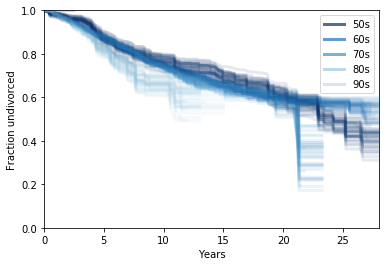

In [92]:
# Solution goes here
ResampleDivorceCurveByDecade([married6, married7])